# Econ 570 Big Data Econometrics - 2nd TA session
Youngmin Ju

# DGP & Monte Carlo Simulation

In [34]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

In [35]:
# Calculate variance
def fn_variance(data, ddof=0): #ddof: "delta degree of freedom": adjustment to the degrees of freedom for the p-value
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [36]:
# Generate covariance
def fn_generate_cov(dim,corr): #dim : dim X dim matrix with diagonal is 1 and others are corr
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

In [39]:
corr=0.5
cov=fn_generate_cov(6,corr)
cov

array([[1. , 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 1. ]])

In [ ]:
# Generate multivariate normal distribution
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1) # Join a sequence of arrays along an existing axis

    cov = fn_generate_cov(nvar,corr) # fn_generate_cov
    C = np.linalg.cholesky(cov) # Cholesky decomposition

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

In [ ]:
# Randomly Choose treated unit
def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [ ]:
# Generate Data (conf: confounder)
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar) # fn_generate_multnorm
  #  W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)

    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

In [ ]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

In [ ]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [ ]:
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX) # fn_generate_data
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc) #fn_tauhat_means            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX) # fn_generate_data
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX) # fn_generate_data
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat] # lower bound
        ub = ub + [tauhat+1.96*se_tauhat] # upper bound
        
    return (n_values,tauhats,sehats,lb,ub)

In [4]:
#  Plotting with Confidence Interval
def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

Statsmodels sandwich variance estimators
https://github.com/statsmodels/statsmodels/blob/master/statsmodels/stats/sandwich_covariance.py

## 1. Experiments with no covariates in the DGP

$y_i = \tau*T_i+e_i$

In [5]:
tau = 2
corr = .5
conf=False # Confounder
p = 10
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|███████████████████████████████████████████████████████████████████████████████| 495/495 [00:03<00:00, 139.44it/s]


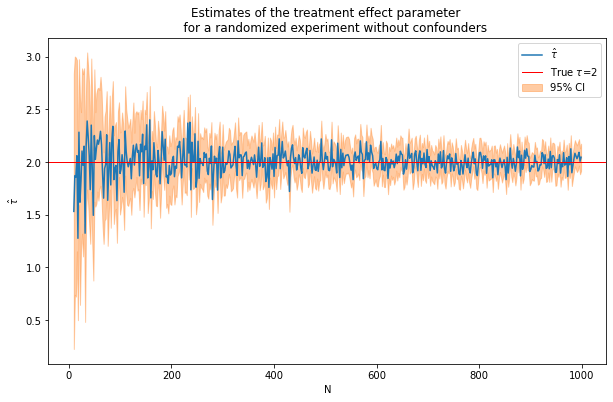

In [6]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

##### For selected N check that this is the same as running a regression with a intercept

In [7]:
# Same process with fn_run_experiments

N = 100
Yexp,T = fn_generate_data(tau,N,10,0,corr,conf = False)
Yt = Yexp[np.where(T==1)[0],:]
Yc = Yexp[np.where(T==0)[0],:]
tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
# n_values = n_values + [N]
# tauhats = tauhats + [tauhat]
lb = lb + [tauhat-1.96*se_tauhat]
ub = ub + [tauhat+1.96*se_tauhat]

In [8]:
tauhat,se_tauhat

(2.4021370455607616, 0.19395861039288148)

In [9]:
# np.linalg.inv(np.transpose(T)@T)@np.transpose(T)@Yexp
const = np.ones([N,1])

In [10]:
model = sm.OLS(Yexp,np.concatenate([T,const],axis = 1))
res = model.fit()
# res.summary()
res.params[0], res.HC1_se[0]

(2.402137045560761, 0.1939586103928815)

#### Run R Monte Carlo iterations and compute bias, RMSE and size

In [11]:
estDict = {}
R = 2000
for N in [10,50,100,500,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:33<00:00, 59.78it/s]


In [12]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    


N=10: bias=-0.01968055225461872, RMSE=0.6433345010248737, size=0.09
N=50: bias=-0.001486741612216921, RMSE=0.2800864398714727, size=0.0505
N=100: bias=-0.009536594843188188, RMSE=0.19687551715639262, size=0.042
N=500: bias=-0.0010245711589984667, RMSE=0.0896230635454456, size=0.0475
N=1000: bias=0.0014414511411529878, RMSE=0.06482022539698959, size=0.06


## 1. Experiments with covariates in the DGP

$y_i = \tau*T_i+\beta'*x_i+e_i$

In [13]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:07<00:00, 66.67it/s]


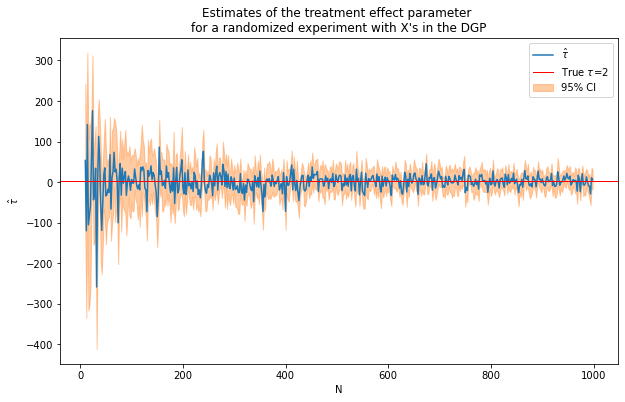

In [14]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

In [15]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 0 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues_x0,tauhats_x0,sehats_x0,lb_x0,ub_x0) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:07<00:00, 66.57it/s]


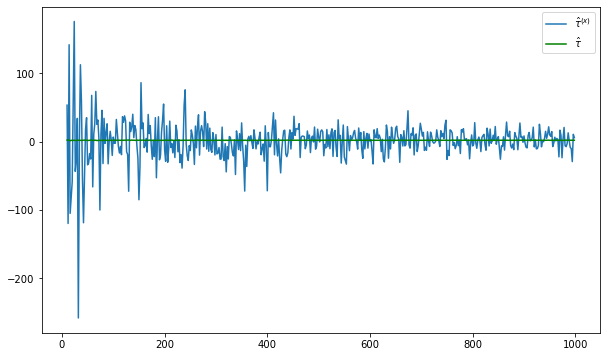

In [16]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x,tauhats_x,label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x,tauhats_x0,label = '$\hat{\\tau}$',color = 'green')
plt.legend()

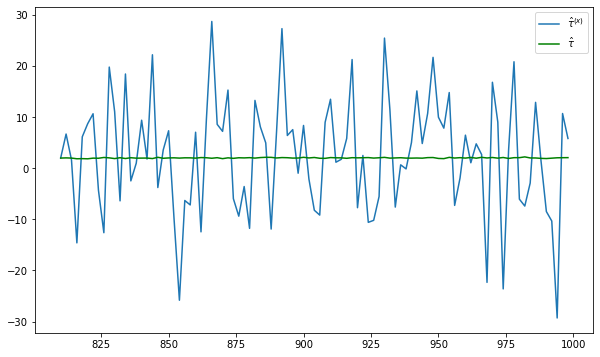

In [17]:
fig = plt.figure(figsize = (10,6))
plt.plot(nvalues_x[400:],tauhats_x[400:],label = '$\hat{\\tau}^{(x)}$')
plt.plot(nvalues_x[400:],tauhats_x0[400:],label = '$\hat{\\tau}$',color = 'green')
plt.legend()

Repeat experiment with larger N

In [18]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(1000,50000,10000) # loop over N values
(nvalues_x2,tauhats_x2,sehats_x2,lb_x2,ub_x2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.96s/it]


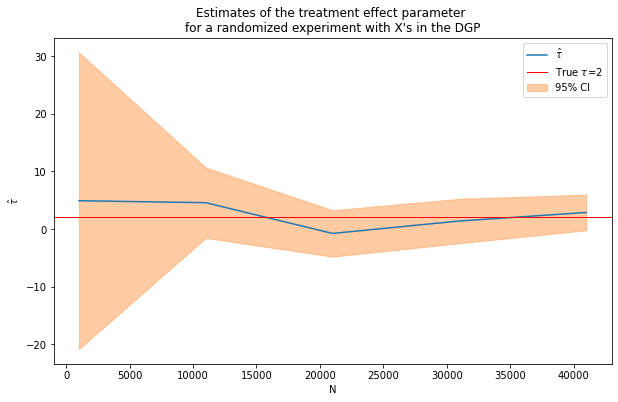

In [19]:
fn_plot_with_ci(nvalues_x2,tauhats_x2,tau,lb_x2,ub_x2,caption)

Still pretty noisy!

## DGP with X - adding covariates to the regression
Use same DGP as before

In [20]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [00:10<00:00, 43.69it/s]


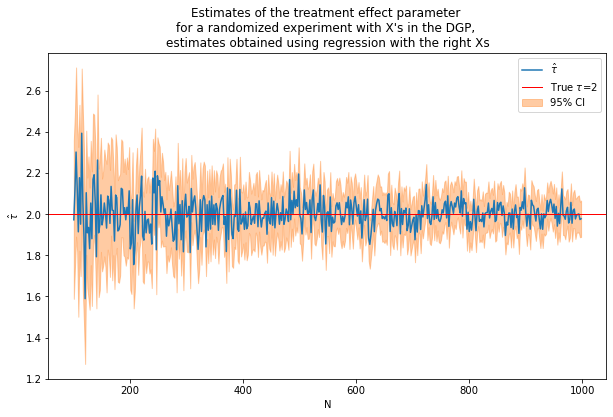

In [21]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

Including X's improves precision. However, we cheated because we included the right X's from the start! 

What happens if we use some X's that influence the outcome and some that don't?

In [22]:
# Use same DGP as
tau = 2
corr = .5
conf=False
p = 1000
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 2
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [01:18<00:00,  5.73it/s]


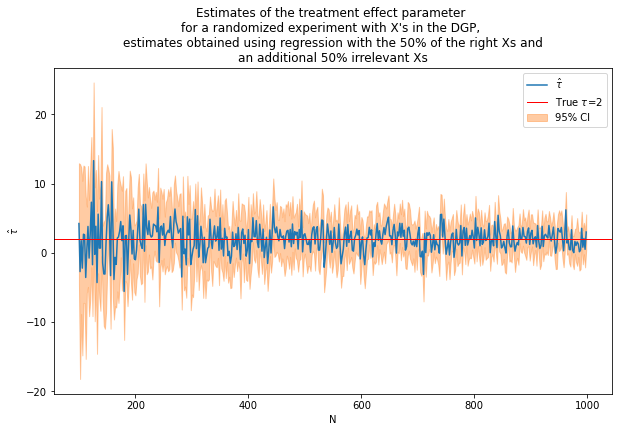

In [23]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the 50% of the right Xs and
an additional 50% irrelevant Xs"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)